# Подготовка данных

In [1]:
import torch 
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import glob
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import os
import cv2 as cv 
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from PIL import Image

In [2]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [3]:
# !unzip /content/gdrive/MyDrive/MADE/DL_intensive/laba-dataset.zip -d /content/gdrive/MyDrive/MADE/DL_intensive/laba_dataset

In [8]:
def normalize(arr):
    """
    Linear normalization
    http://en.wikipedia.org/wiki/Normalization_%28image_processing%29
    """
    arr = arr.astype('float')
    # Do not touch the alpha channel
    for i in range(3):
        minval = arr[...,i].min()
        maxval = arr[...,i].max()
        if minval != maxval:
            arr[...,i] -= minval
            arr[...,i] *= (255.0/(maxval-minval))
    return arr

def batch_mean_and_sd(loader):
    
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, _ in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2,
                                  dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (
                      cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (
                            cnt + nb_pixels)
        cnt += nb_pixels

    mean, std = fst_moment, torch.sqrt(
      snd_moment - fst_moment ** 2)        
    return mean,std

In [9]:
transform_img = transforms.Compose([
    transforms.ToTensor(),
    # here do not use transforms.Normalize(mean, std)
])

In [10]:
path = '/content/gdrive/MyDrive/MADE/DL_intensive/laba_dataset/samples'

class CustomDataset(Dataset):
    def __init__(self, path, targets, transform = None):
        self.imgs_path = path
        self.file_list = path
        self.targets = targets
        self.transform = transform
        
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        path = self.file_list[idx]
        # img = cv.imread(path) 
        img = Image.open(path)
        img = img.convert('RGB')
        img = np.array(img) 
        label = self.targets[idx]
        # mean = img.mean()
        # std = img.std()
        # img = (img - mean) / std
        # img = torch.from_numpy(img)
        # img=img.float()
        if self.transform:
          img = self.transform(img)
        
        # return {
        #     "images": torch.tensor(img, dtype=torch.float),
        #     "targets": torch.tensor(label, dtype=torch.long),
        # }
        return torch.tensor(img, dtype=torch.float), torch.tensor(label, dtype=torch.long)

# dataset = CustomDataset(path, transform_img)
# dataloader = DataLoader(dataset, batch_size=4, pin_memory=True)

In [7]:
# lets calculate mean and std for the dataaset
mean, std = batch_mean_and_sd(dataloader)
print("mean and std: \n", mean, std)

NameError: ignored

In [11]:
transform_img_normal = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.7152, 0.7152, 0.7152],
                         std= [0.3137, 0.3137, 0.3137])
])

# dataset = CustomDataset(path, transform_img_normal)
# dataloader = DataLoader(dataset, batch_size=4, pin_memory=True)

In [12]:
# train_size = int(0.75 * len(dataset))
# test_size = len(dataset) - train_size

image_files = glob.glob(os.path.join(path, "*.png"))
targets_orig = [x.split('/')[-1].split('.')[0] for x in image_files]
targets = [[c for c in x] for x in targets_orig]
targets_flat = [c for clist in targets for c in clist]

lbl_enc = preprocessing.LabelEncoder()
lbl_enc.fit(targets_flat)
targets_enc = [lbl_enc.transform(x) for x in targets]
targets_enc = np.array(targets_enc)
targets_enc = targets_enc + 1

train_imgs, test_imgs, train_targets, test_targets, _, test_targets_orig = train_test_split(image_files, targets_enc, targets_orig, test_size=0.1, random_state=42)

train_dataset = CustomDataset(train_imgs, train_targets, transform_img_normal)

train_loader = dataloader = DataLoader(train_dataset, batch_size=4, pin_memory=True, shuffle=True)
# torch.utils.data.DataLoader(
#     train_dataset,
#     batch_size=config.BATCH_SIZE,
#     num_workers=config.NUM_WORKERS,
#     shuffle=True,
# )
test_dataset = CustomDataset(test_imgs, test_targets, transform_img_normal)

# dataset.ClassificationDataset(
#     image_paths=test_imgs,
#     targets=test_targets,
#     resize=(config.IMAGE_HEIGHT, config.IMAGE_WIDTH),
# )
test_loader = DataLoader(test_dataset, batch_size=4, pin_memory=True, shuffle=False)
# torch.utils.data.DataLoader(
#     test_dataset,
#     batch_size=config.BATCH_SIZE,
#     num_workers=config.NUM_WORKERS,
#     shuffle=False,
# )


# train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
# train_loader = DataLoader(train_dataset, batch_size=4, pin_memory=True)
# test_loader = DataLoader(test_dataset, batch_size=4, pin_memory=True)

<ipython-input-10-6e3cd6adde2d>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(img, dtype=torch.float), torch.tensor(label, dtype=torch.long)


images torch.Size([4, 3, 50, 200])
Label: tensor([[ 3,  2, 13, 11, 19],
        [19,  4, 10, 16, 16],
        [ 2,  7, 15,  4,  6],
        [ 4,  5, 15,  9, 18]])


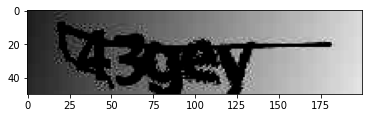

In [13]:
# Display image and label.
data = next(iter(train_loader))
# img = data['images']
# label = data['targets']
img = data[0]
label = data[1]

print('images', img.shape)
print(f"Label: {label}")
plt.imshow(img[0].permute(1,2,0))

# Создание и обучение модели

In [ ]:
'''
predictions after model are the same as for indus, so make the function decoder the same as he
'''

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
alphabet = '0123456789abcdefghijklmnopqrstuvwxyz'
alph = lbl_enc.classes_
n_classes = len(alph) + 1

In [15]:
def train_fn(model, data_loader, optimizer):
    model.train()
    fin_loss = 0
    tk0 = tqdm(data_loader, total=len(data_loader))
    for data in tk0:
        data[0] = data[0].to(device)
        data[1] = data[1].to(device)
        optimizer.zero_grad()
        out, loss = model(data[0], data[1])
        loss.backward()
        nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
        optimizer.step()
        fin_loss += loss.item()
    return fin_loss / len(data_loader)


def eval_fn(model, data_loader):
    model.eval()
    fin_loss = 0
    fin_preds = []
    with torch.no_grad():
      tk0 = tqdm(data_loader, total=len(data_loader))
      for data in tk0:
          data[0] = data[0].to(device)
          data[1] = data[1].to(device)
          batch_preds, loss = model(data[0], data[1])
          fin_loss += loss.item()
          fin_preds.append(batch_preds)
      return fin_preds, fin_loss / len(data_loader)

def train():
  model = CRNN()
  model.to(device)

  optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
      optimizer, factor=0.8, patience=5, verbose=True
  )
  for epoch in range(2):
      train_loss = train_fn(model, train_loader, optimizer)
      valid_preds, test_loss = eval_fn(model, test_loader)
      valid_captcha_preds = []
      for vp in valid_preds:
          current_preds = decode_predictions(vp, lbl_enc)
          valid_captcha_preds.extend(current_preds)
      combined = list(zip(test_targets_orig, valid_captcha_preds))
      print(combined[:10])
      test_dup_rem = [remove_duplicates(c) for c in test_targets_orig]
      accuracy = metrics.accuracy_score(test_dup_rem, valid_captcha_preds)
      print(
          f"Epoch={epoch}, Train Loss={train_loss}, Test Loss={test_loss} Accuracy={accuracy}"
      )
      scheduler.step(test_loss)

def remove_duplicates(x):
    if len(x) < 2:
        return x
    fin = ""
    for j in x:
        if fin == "":
            fin = j
        else:
            if j == fin[-1]:
                continue
            else:
                fin = fin + j
    return fin

def decode_predictions(preds, encoder):
    preds = preds.permute(1, 0, 2)
    # print('before softmax and after permuattion', preds.shape)
    preds = torch.softmax(preds, 2)
    # print('why softmax?', preds.shape)
    # print('preds', preds[0])
    preds = torch.argmax(preds, 2)
    # print('preds.argmax', preds[0])
    preds = preds.detach().cpu().numpy()
    cap_preds = []
    for j in range(preds.shape[0]):
        temp = []
        for k in preds[j, :]:
            k = k - 1
            if k == -1:
                temp.append("§")
            else:
                p = encoder.inverse_transform([k])[0]
                temp.append(p)
        tp = "".join(temp).replace("§", "")
        cap_preds.append(remove_duplicates(tp))
    # print('temp', temp)
    # print('tp', tp)

    return cap_preds

In [16]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()

        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)

    def forward(self, input):
        recurrent, _ = self.rnn(input)
        b, T, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)
        # t_rec = recurrent.permute(1, 0 ,2)

        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)

        return output


class CRNN(nn.Module):

    def __init__(self):
        super(CRNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3, 3), padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=(3, 3), padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=(2, 2), padding=0)
        self.pool5 = nn.MaxPool2d(2, 1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=(4, 2))
        self.rnn = nn.LSTM(256, 128, num_layers=2, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(256, n_classes)

    def forward(self, x, targets):
        batch_size = x.shape[0]
        out = self.conv1(x)
        out = self.pool1(out)
        out = F.leaky_relu(out)
        out = self.conv2(out)
        out = self.pool2(out)
        out = F.leaky_relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out = F.leaky_relu(out)
        out = self.conv4(out)
        out = self.pool4(out)
        out = F.leaky_relu(out)
        out = self.conv5(out)
        out = self.pool5(out)
        out = self.bn5(out)
        out = F.leaky_relu(out)
        out = self.conv6(out)
        out = F.leaky_relu(out)
        out = out.squeeze(2)
        out = out.permute(0, 2, 1) # [b, w, h, c]
        out, _ = self.rnn(out)
        out = self.linear(out)
        out = out.permute(1, 0, 2)
        log_probs = F.log_softmax(out, 2)
        input_lengths = torch.full(size=(4,), fill_value=log_probs.size(0), dtype=torch.int32)
        target_lengths = torch.full(size=(4,), fill_value=targets.size(1), dtype=torch.int32)
        loss = nn.CTCLoss(blank=10)(log_probs, targets, input_lengths, target_lengths)

        return out, loss



In [17]:
pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 15.7 MB/s eta 0:00:00


In [18]:
from torchmetrics.functional import char_error_rate

In [19]:
model = CRNN()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.8, patience=5, verbose=True
)
for epoch in range(20):
    train_loss = train_fn(model, train_loader, optimizer)
    valid_preds, test_loss = eval_fn(model, test_loader)
    print(f'epoch {epoch}, train loss: {train_loss}, test loss: {test_loss}')
    valid_captcha_preds = []
    # print('len valid_preds', len(valid_preds))
    # print('valid_preds', valid_preds[0].shape)
    for vp in valid_preds:
        current_preds = decode_predictions(vp, lbl_enc)
        valid_captcha_preds.extend(current_preds)
    # print('current_preds', current_preds)
    # print('valid_captcha_preds', valid_captcha_preds)
    combined = list(zip(test_targets_orig, valid_captcha_preds))
    print(combined[:10])
    test_dup_rem = [remove_duplicates(c) for c in test_targets_orig]
    # print('test_dup_rem', test_dup_rem)
    accuracy = accuracy_score(test_dup_rem, valid_captcha_preds)
    cer = char_error_rate(test_dup_rem, valid_captcha_preds)
    print(
        f"Epoch={epoch}, Train Loss={train_loss}, Test Loss={test_loss} Accuracy={accuracy} CER={cer}"
    )
    scheduler.step(test_loss)
print('final cer', cer)

  0%|          | 0/234 [00:00<?, ?it/s]<ipython-input-10-6e3cd6adde2d>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(img, dtype=torch.float), torch.tensor(label, dtype=torch.long)
100%|██████████| 26/26 [00:02<00:00, 10.87it/s]


epoch 0, train loss: 3.1293254632216234, test loss: 2.945602875489455
[('dnxdp', 'd'), ('m3wfw', 'd'), ('7bwm2', 'd'), ('3nnpw', 'd'), ('pm363', 'd'), ('x362g', 'd'), ('g247w', 'd'), ('bgb48', 'd'), ('8cm46', 'd'), ('4n3mn', 'd')]
Epoch=0, Train Loss=3.1293254632216234, Test Loss=2.945602875489455 Accuracy=0.0 CER=4.625


  0%|          | 0/234 [00:00<?, ?it/s]<ipython-input-10-6e3cd6adde2d>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(img, dtype=torch.float), torch.tensor(label, dtype=torch.long)
100%|██████████| 26/26 [00:02<00:00, 12.49it/s]


epoch 1, train loss: 2.9189328245627575, test loss: 2.9338804941910963
[('dnxdp', 'd'), ('m3wfw', 'd'), ('7bwm2', 'd'), ('3nnpw', 'd'), ('pm363', 'd'), ('x362g', 'd'), ('g247w', 'd'), ('bgb48', 'd'), ('8cm46', 'd'), ('4n3mn', 'd')]
Epoch=1, Train Loss=2.9189328245627575, Test Loss=2.9338804941910963 Accuracy=0.0 CER=4.625


  0%|          | 0/234 [00:00<?, ?it/s]<ipython-input-10-6e3cd6adde2d>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(img, dtype=torch.float), torch.tensor(label, dtype=torch.long)
100%|██████████| 26/26 [00:02<00:00,  9.71it/s]


epoch 2, train loss: 2.8480534976364202, test loss: 2.8224500050911536
[('dnxdp', 'd'), ('m3wfw', 'd'), ('7bwm2', 'd'), ('3nnpw', 'd'), ('pm363', 'd'), ('x362g', 'd'), ('g247w', 'd'), ('bgb48', 'd'), ('8cm46', 'd'), ('4n3mn', 'd')]
Epoch=2, Train Loss=2.8480534976364202, Test Loss=2.8224500050911536 Accuracy=0.0 CER=4.625


  0%|          | 0/234 [00:00<?, ?it/s]<ipython-input-10-6e3cd6adde2d>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(img, dtype=torch.float), torch.tensor(label, dtype=torch.long)
100%|██████████| 26/26 [00:02<00:00, 12.50it/s]


epoch 3, train loss: 2.3985045154889426, test loss: 1.959514292386862
[('dnxdp', 'd'), ('m3wfw', 'd'), ('7bwm2', 'd'), ('3nnpw', 'd'), ('pm363', 'd'), ('x362g', 'd'), ('g247w', 'd'), ('bgb48', 'd'), ('8cm46', 'd'), ('4n3mn', 'd')]
Epoch=3, Train Loss=2.3985045154889426, Test Loss=1.959514292386862 Accuracy=0.0 CER=4.625


  0%|          | 0/234 [00:00<?, ?it/s]<ipython-input-10-6e3cd6adde2d>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(img, dtype=torch.float), torch.tensor(label, dtype=torch.long)
100%|██████████| 26/26 [00:02<00:00, 12.33it/s]


epoch 4, train loss: 1.106950832833337, test loss: 0.3418266664330776
[('dnxdp', 'dndxdpd'), ('m3wfw', 'dnd3dwdfdwd'), ('7bwm2', 'd7dbdwdnd2d'), ('3nnpw', 'd3dndndpdwd'), ('pm363', 'dpdnd3d6d3d'), ('x362g', 'dxd3d6d2dgd'), ('g247w', 'dgd2d4d7dwd'), ('bgb48', 'dbdgdbd4d8d'), ('8cm46', 'd8dcdnd4d6d'), ('4n3mn', 'd4dnd3dmdnd')]
Epoch=4, Train Loss=1.106950832833337, Test Loss=0.3418266664330776 Accuracy=0.0 CER=0.5694572329521179


  0%|          | 0/234 [00:00<?, ?it/s]<ipython-input-10-6e3cd6adde2d>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(img, dtype=torch.float), torch.tensor(label, dtype=torch.long)
100%|██████████| 26/26 [00:02<00:00, 12.47it/s]


epoch 5, train loss: 0.06320766338871585, test loss: 0.003984422637866094
[('dnxdp', 'dndxdpd'), ('m3wfw', 'dmd3dwdfdwd'), ('7bwm2', 'd7dbdwdmd2d'), ('3nnpw', 'd3dndndpdwd'), ('pm363', 'dpdnd3d6d3d'), ('x362g', 'dxd3d6d2dgd'), ('g247w', 'dgd2d4d7dwd'), ('bgb48', 'dbdgdbd4d8d'), ('8cm46', 'd8dcdmd4d6d'), ('4n3mn', 'd4dnd3dmdnd')]
Epoch=5, Train Loss=0.06320766338871585, Test Loss=0.003984422637866094 Accuracy=0.0 CER=0.5510948896408081


  0%|          | 0/234 [00:00<?, ?it/s]<ipython-input-10-6e3cd6adde2d>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(img, dtype=torch.float), torch.tensor(label, dtype=torch.long)
100%|██████████| 26/26 [00:02<00:00, 12.48it/s]


epoch 6, train loss: -0.05348807371133923, test loss: -0.059146215279514976
[('dnxdp', 'dndxdpd'), ('m3wfw', 'dmd3dwdfdwd'), ('7bwm2', 'd7dbdwdmd2d'), ('3nnpw', 'd3dndndpdwd'), ('pm363', 'dpdnd3d6d3d'), ('x362g', 'dxd3d6d2dgd'), ('g247w', 'dgd2d4d7dwd'), ('bgb48', 'dbdgdbd4d8d'), ('8cm46', 'd8dcdmd4d6d'), ('4n3mn', 'd4dnd3dmdnd')]
Epoch=6, Train Loss=-0.05348807371133923, Test Loss=-0.059146215279514976 Accuracy=0.0 CER=0.5437158346176147


  0%|          | 0/234 [00:00<?, ?it/s]<ipython-input-10-6e3cd6adde2d>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(img, dtype=torch.float), torch.tensor(label, dtype=torch.long)
100%|██████████| 26/26 [00:02<00:00, 10.47it/s]


epoch 7, train loss: -0.10551659335804164, test loss: -0.10287077796573822
[('dnxdp', 'dndxdpd'), ('m3wfw', 'dmd3dwdfdwd'), ('7bwm2', 'd7dbdwdmd2d'), ('3nnpw', 'd3dndndpdwd'), ('pm363', 'dpdmd3d6d3d'), ('x362g', 'dxd3d6d2dgd'), ('g247w', 'dgd2d4d7dwd'), ('bgb48', 'dbdgdbd4d8d'), ('8cm46', 'd8dcdmd4d6d'), ('4n3mn', 'd4dnd3dmdnd')]
Epoch=7, Train Loss=-0.10551659335804164, Test Loss=-0.10287077796573822 Accuracy=0.0 CER=0.5419707894325256


  0%|          | 0/234 [00:00<?, ?it/s]<ipython-input-10-6e3cd6adde2d>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(img, dtype=torch.float), torch.tensor(label, dtype=torch.long)
100%|██████████| 26/26 [00:02<00:00, 11.88it/s]


epoch 8, train loss: -0.12124207560928205, test loss: -0.10970070743216918
[('dnxdp', 'dndxdpd'), ('m3wfw', 'dmd3dwdfdwd'), ('7bwm2', 'd7dbdwdmd2d'), ('3nnpw', 'd3dndndpdwd'), ('pm363', 'dpdmd3d6d3d'), ('x362g', 'dxd3d6d2dgd'), ('g247w', 'dgd2d4d7dwd'), ('bgb48', 'dbdgdbd4d8d'), ('8cm46', 'd8dcdmd4d6d'), ('4n3mn', 'd4dnd3dmdnd')]
Epoch=8, Train Loss=-0.12124207560928205, Test Loss=-0.10970070743216918 Accuracy=0.0 CER=0.5419707894325256


  0%|          | 0/234 [00:00<?, ?it/s]<ipython-input-10-6e3cd6adde2d>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(img, dtype=torch.float), torch.tensor(label, dtype=torch.long)
100%|██████████| 26/26 [00:03<00:00,  8.26it/s]


epoch 9, train loss: -0.12276643441201976, test loss: -0.11128565235636555
[('dnxdp', 'dndxdpd'), ('m3wfw', 'dmd3dwdfdwd'), ('7bwm2', 'd7dbdwdmd2d'), ('3nnpw', 'd3dndndpdwd'), ('pm363', 'dpdmd3d6d3d'), ('x362g', 'dxd3d6d2dgd'), ('g247w', 'dgd2d4d7dwd'), ('bgb48', 'dbdgdbd4d8d'), ('8cm46', 'd8dcdmd4d6d'), ('4n3mn', 'd4dnd3dmdnd')]
Epoch=9, Train Loss=-0.12276643441201976, Test Loss=-0.11128565235636555 Accuracy=0.0 CER=0.5419707894325256


  0%|          | 0/234 [00:00<?, ?it/s]<ipython-input-10-6e3cd6adde2d>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(img, dtype=torch.float), torch.tensor(label, dtype=torch.long)
100%|██████████| 26/26 [00:02<00:00, 12.55it/s]


epoch 10, train loss: -0.1130049961587239, test loss: 0.05054385573245012
[('dnxdp', 'dndxdpd'), ('m3wfw', 'dmd3dwdfdwd'), ('7bwm2', 'd7dbdwdmd2d'), ('3nnpw', 'd3dwdndpdwd'), ('pm363', 'dpdmd6d3d'), ('x362g', 'dxd3d6d2dgd'), ('g247w', 'dgd2d4d7dwd'), ('bgb48', 'dbdgdbd4d8d'), ('8cm46', 'd8dcdwd4d6d'), ('4n3mn', 'd4dnd3dwdnd')]
Epoch=10, Train Loss=-0.1130049961587239, Test Loss=0.05054385573245012 Accuracy=0.0 CER=0.5558608174324036


  0%|          | 0/234 [00:00<?, ?it/s]<ipython-input-10-6e3cd6adde2d>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(img, dtype=torch.float), torch.tensor(label, dtype=torch.long)
100%|██████████| 26/26 [00:03<00:00,  8.65it/s]


epoch 11, train loss: -0.12205477902848814, test loss: -0.11748539953707503
[('dnxdp', 'dndxdpd'), ('m3wfw', 'dmd3dwdfdwd'), ('7bwm2', 'd7dbdwdmd2d'), ('3nnpw', 'd3dndndpdwd'), ('pm363', 'dpdmd3d6d3d'), ('x362g', 'dxd3d6d2dgd'), ('g247w', 'dgd2d4d7dwd'), ('bgb48', 'dbdgdbd4d8d'), ('8cm46', 'd8dcdmd4d6d'), ('4n3mn', 'd4dnd3dmdnd')]
Epoch=11, Train Loss=-0.12205477902848814, Test Loss=-0.11748539953707503 Accuracy=0.0 CER=0.5419707894325256


  0%|          | 0/234 [00:00<?, ?it/s]<ipython-input-10-6e3cd6adde2d>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(img, dtype=torch.float), torch.tensor(label, dtype=torch.long)
100%|██████████| 26/26 [00:02<00:00, 12.38it/s]


epoch 12, train loss: -0.1326014330574813, test loss: -0.10409213914177738
[('dnxdp', 'dndxdpd'), ('m3wfw', 'dmd3dwdfdwd'), ('7bwm2', 'd7dbdwdmd2d'), ('3nnpw', 'd3dndndpdwd'), ('pm363', 'dpdmd3d6d3d'), ('x362g', 'dxd3d6d2dgd'), ('g247w', 'dgd2d4d7dwd'), ('bgb48', 'dbdgdbd4d8d'), ('8cm46', 'd8dcdmd4d6d'), ('4n3mn', 'd4dnd3dmdnd')]
Epoch=12, Train Loss=-0.1326014330574813, Test Loss=-0.10409213914177738 Accuracy=0.0 CER=0.543795645236969


  0%|          | 0/234 [00:00<?, ?it/s]<ipython-input-10-6e3cd6adde2d>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(img, dtype=torch.float), torch.tensor(label, dtype=torch.long)
100%|██████████| 26/26 [00:02<00:00, 11.37it/s]


epoch 13, train loss: -0.13388551930343717, test loss: -0.12040298159878987
[('dnxdp', 'dndxdpd'), ('m3wfw', 'dmd3dwdfdwd'), ('7bwm2', 'd7dbdwdmd2d'), ('3nnpw', 'd3dndndpdwd'), ('pm363', 'dpdmd3d6d3d'), ('x362g', 'dxd3d6d2dgd'), ('g247w', 'dgd2d4d7dwd'), ('bgb48', 'dbdgdbd4d8d'), ('8cm46', 'd8dcdmd4d6d'), ('4n3mn', 'd4dnd3dmdnd')]
Epoch=13, Train Loss=-0.13388551930343717, Test Loss=-0.12040298159878987 Accuracy=0.0 CER=0.5419707894325256


  0%|          | 0/234 [00:00<?, ?it/s]<ipython-input-10-6e3cd6adde2d>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(img, dtype=torch.float), torch.tensor(label, dtype=torch.long)
100%|██████████| 26/26 [00:02<00:00, 10.73it/s]


epoch 14, train loss: -0.12034185464955612, test loss: -0.11576414971540754
[('dnxdp', 'dndxdpd'), ('m3wfw', 'dmd3dwdfdwd'), ('7bwm2', 'd7dbdwdmd2d'), ('3nnpw', 'd3dndndpdwd'), ('pm363', 'dpdmd3d6d3d'), ('x362g', 'dxd3d6d2dgd'), ('g247w', 'dgd2d4d7dwd'), ('bgb48', 'dbdgdbd4d8d'), ('8cm46', 'd8dcdmd4d6d'), ('4n3mn', 'd4dnd3dmdnd')]
Epoch=14, Train Loss=-0.12034185464955612, Test Loss=-0.11576414971540754 Accuracy=0.0 CER=0.5420475602149963


  0%|          | 0/234 [00:00<?, ?it/s]<ipython-input-10-6e3cd6adde2d>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(img, dtype=torch.float), torch.tensor(label, dtype=torch.long)
100%|██████████| 26/26 [00:02<00:00, 12.48it/s]


epoch 15, train loss: -0.13066765504519048, test loss: -0.12052406774511418
[('dnxdp', 'dndxdpd'), ('m3wfw', 'dmd3dwdfdwd'), ('7bwm2', 'd7dbdwdmd2d'), ('3nnpw', 'd3dndndpdwd'), ('pm363', 'dpdmd3d6d3d'), ('x362g', 'dxd3d6d2dgd'), ('g247w', 'dgd2d4d7dwd'), ('bgb48', 'dbdgdbd4d8d'), ('8cm46', 'd8dcdmd4d6d'), ('4n3mn', 'd4dnd3dmdnd')]
Epoch=15, Train Loss=-0.13066765504519048, Test Loss=-0.12052406774511418 Accuracy=0.0 CER=0.5419707894325256


  0%|          | 0/234 [00:00<?, ?it/s]<ipython-input-10-6e3cd6adde2d>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(img, dtype=torch.float), torch.tensor(label, dtype=torch.long)
100%|██████████| 26/26 [00:03<00:00,  8.44it/s]


epoch 16, train loss: -0.13323813181521738, test loss: -0.11491303520205502
[('dnxdp', 'dndxdpd'), ('m3wfw', 'dmd3dwdfdwd'), ('7bwm2', 'd7dbdwdmd2d'), ('3nnpw', 'd3dndndpdwd'), ('pm363', 'dpdmd3d6d3d'), ('x362g', 'dxd3d6d2dgd'), ('g247w', 'dgd2d4d7dwd'), ('bgb48', 'dbdgdbd4d8d'), ('8cm46', 'd8dcdmd4d6d'), ('4n3mn', 'd4dnd3dmdnd')]
Epoch=16, Train Loss=-0.13323813181521738, Test Loss=-0.11491303520205502 Accuracy=0.0 CER=0.5428832173347473


  0%|          | 0/234 [00:00<?, ?it/s]<ipython-input-10-6e3cd6adde2d>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(img, dtype=torch.float), torch.tensor(label, dtype=torch.long)
100%|██████████| 26/26 [00:02<00:00, 12.44it/s]


epoch 17, train loss: -0.12370349905795903, test loss: -0.11093054027654804
[('dnxdp', 'dndxdpd'), ('m3wfw', 'dmd3dwdfdwd'), ('7bwm2', 'd7dbdwdmd2d'), ('3nnpw', 'd3dndndpdwd'), ('pm363', 'dpdmd3d6d3d'), ('x362g', 'dxd3d6d2dgd'), ('g247w', 'dgd2d4d7dwd'), ('bgb48', 'dbdgdbd4d8d'), ('8cm46', 'd8dcdmd4d6d'), ('4n3mn', 'd4dnd3dmdnd')]
Epoch=17, Train Loss=-0.12370349905795903, Test Loss=-0.11093054027654804 Accuracy=0.0 CER=0.5420475602149963


  0%|          | 0/234 [00:00<?, ?it/s]<ipython-input-10-6e3cd6adde2d>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(img, dtype=torch.float), torch.tensor(label, dtype=torch.long)
100%|██████████| 26/26 [00:02<00:00, 12.30it/s]


epoch 18, train loss: -0.13083314889858866, test loss: -0.12059138922128253
[('dnxdp', 'dndxdpd'), ('m3wfw', 'dmd3dwdfdwd'), ('7bwm2', 'd7dbdwdmd2d'), ('3nnpw', 'd3dndndpdwd'), ('pm363', 'dpdmd3d6d3d'), ('x362g', 'dxd3d6d2dgd'), ('g247w', 'dgd2d4d7dwd'), ('bgb48', 'dbdgdbd4d8d'), ('8cm46', 'd8dcdmd4d6d'), ('4n3mn', 'd4dnd3dmdnd')]
Epoch=18, Train Loss=-0.13083314889858866, Test Loss=-0.12059138922128253 Accuracy=0.0 CER=0.5419707894325256


  0%|          | 0/234 [00:00<?, ?it/s]<ipython-input-10-6e3cd6adde2d>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(img, dtype=torch.float), torch.tensor(label, dtype=torch.long)
100%|██████████| 26/26 [00:02<00:00, 10.70it/s]


epoch 19, train loss: -0.1353358458667898, test loss: -0.12640478641081315
[('dnxdp', 'dndxdpd'), ('m3wfw', 'dmd3dwdfdwd'), ('7bwm2', 'd7dbdwdmd2d'), ('3nnpw', 'd3dndndpdwd'), ('pm363', 'dpdmd3d6d3d'), ('x362g', 'dxd3d6d2dgd'), ('g247w', 'dgd2d4d7dwd'), ('bgb48', 'dbdgdbd4d8d'), ('8cm46', 'd8dcdmd4d6d'), ('4n3mn', 'd4dnd3dmdnd')]
Epoch=19, Train Loss=-0.1353358458667898, Test Loss=-0.12640478641081315 Accuracy=0.0 CER=0.5419707894325256
final cer tensor(0.5420)


Улучшение модели было произведено засчет клиппинга градиентов и увеличением числа эпох, до этого прогнозировались пустые значения или одна и та же последовательность длиной 1. 